## Mex Local Rates systematic signals
I am going to explore, which way of constructing the interest rate butterfly produces best trade for mean-reversion strategy with Mexican MBONOs market as a example. I am going to utilise history of fitted zero-coupon curves that I estimated from 12 years of cash bond prices.

In [8]:
import pandas as pd
import numpy as np
import cufflinks as cf
import matplotlib.pyplot as plt
import sqlite3
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
from math import log, sqrt
from tqdm import tqdm

plt.style.use('ggplot')

In [2]:
#Retrieveing history of Zero Curve
con = sqlite3.connect("./db/MBONOdata.db")
query = """SELECT * from ZeroCurves;"""
df_zc = 100 * pd.read_sql_query(query, con, parse_dates=['Date'],
                                index_col='Date').sort_index()

In [3]:
#Fubnction for estimating buttefly weights based on PCA of zero curve
def get_pca_bf_weights(zc_data):
    cov = zc_data.cov()
    eig_vals, eig_vecs = np.linalg.eig(cov)
    permutation = np.argsort(-eig_vals)
    eig_vals = eig_vals[permutation]
    eig_vecs = eig_vecs[:, permutation]
    A = eig_vecs.T
    A[2] = [0, 1, 0]
    bf_weights = np.linalg.inv(A) @ np.array([[0], [0], [1]])
    return bf_weights

#Estimating Ornstein-Uhlenbeck parameters
def fit_ou_params(x):
    reg = sm.OLS(x[1:],sm.add_constant(x[:-1])).fit()
    theta = -log(reg.params[1])
    mu = reg.params[0] / (1 - reg.params[1])
    sigma_eq = np.std(reg.resid) / sqrt((1 - reg.params[1] ** 2))
    hl = log(2) / theta
    return theta, mu, sigma_eq, hl

In [4]:
#Auxiliary functions to generate trades for mean-reversion trading bands
def get_position(z_scores, ol=-2, cl=-1, os=2, cs=1):
    position = pd.DataFrame(0, index=z_scores.index, columns=z_scores.columns)
    position.iloc[0] = np.where(z_scores.iloc[0] <= ol, 1, np.where(z_scores.iloc[0] >= os, -1, 0))
    for i in range(1, len(z_scores.index)):
        position.iloc[i] = np.where(z_scores.iloc[i] <= ol, 1, np.where(z_scores.iloc[i] >= os, -1,
            np.where((z_scores.iloc[i] < cl) & (position.iloc[i-1] == 1), 1,
            np.where((z_scores.iloc[i] > cs) & (position.iloc[i-1] == -1), -1, 0))))
    return position

def get_trades(position):
    trades = position.diff()
    trades.iloc[0] = position.iloc[0]
    trades.iloc[-1] = -position.iloc[-2]
    return trades

def evaluate_strategy(weights, test_ts, mu, sigma, ol, cl, os, cs, tc):
    signal = (test_ts - mu) / sigma
    position = get_position(signal, ol, cl, os, cs)
    pnl = (test_ts.diff().shift(-1) * position)
    trades = get_trades(position)
    costs = (trades.abs() * np.sum(np.abs(weights)) * tc)
    return pnl, costs

Trading strategy based on mean-reversion of butterflies. Parameters are estimated yearly based on five years lookback period. Three methods of butterfly weighting are used: baseline duration weighted, weights generated by the Johansen procedure and PCA-based (applied to levels)

In [14]:
tenors = ['Y2', 'Y3', 'Y5', 'Y10', 'Y20']

lookback_years = 5
test_years = 1
p_val_crit = 0.05
hl_crit = 20
sigma_crit = 0.025
z_ol = -1.5
z_cl = -.5
z_os = 1.5
z_cs = .5
trading_costs = 0.005

eoy = pd.date_range(end=df_zc.index[-1], start = df_zc.index[0], freq='BY')
df_pca_pnl = pd.DataFrame(index=df_zc[df_zc.index > eoy[lookback_years-1]].index)
df_jo_pnl = df_pca_pnl.copy()
df_dv_pnl = df_pca_pnl.copy()
df_pca_costs = df_pca_pnl.copy()
df_jo_costs = df_pca_pnl.copy()
df_dv_costs = df_pca_pnl.copy()

dv_bf_weights = np.array([-0.5, 1.0, -0.5]).reshape(-1,1)
                
for i in tqdm(range(lookback_years-1, len(eoy), 1)):
    idx = pd.bdate_range(start=eoy[i] + pd.tseries.offsets.DateOffset(years=-lookback_years), end=eoy[i])
    train_idx = df_zc.index.intersection(idx)
    idx = pd.bdate_range(end=eoy[i] + pd.tseries.offsets.DateOffset(years=test_years),
                        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1))
    test_idx = df_zc.index.intersection(idx)
    for j, t1 in enumerate(tenors):
        for k, t2 in enumerate(tenors[j+1:]):
            for t3 in tenors[j+k+2:]:
                dv_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(dv_bf_weights)
                if adfuller(dv_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl = fit_ou_params(dv_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        dv_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(dv_bf_weights)
                        pnl, costs = evaluate_strategy(dv_bf_weights, dv_bf_test, mu, sigma_eq,
                                                    z_ol, z_cl, z_os, z_cs, trading_costs)
                        df_dv_pnl.loc[test_idx, f'{t1}-{t2}-{t3}'] = pnl.iloc[:,0]
                        df_dv_costs.loc[test_idx, f'{t1}-{t2}-{t3}'] = costs.iloc[:,0]
                pca_bf_weights = get_pca_bf_weights(df_zc.loc[train_idx, [t1, t2, t3]])
                pca_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(pca_bf_weights)
                if adfuller(pca_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl  = fit_ou_params(pca_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        pca_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(pca_bf_weights)
                        pnl, costs = evaluate_strategy(pca_bf_weights, pca_bf_test, mu, sigma_eq,
                                                    z_ol, z_cl, z_os, z_cs, trading_costs)
                        df_pca_pnl.loc[test_idx, f'{t1}-{t2}-{t3}'] = pnl.iloc[:,0]
                        df_pca_costs.loc[test_idx, f'{t1}-{t2}-{t3}'] = costs.iloc[:,0]
                johansen = coint_johansen(df_zc.loc[train_idx, [t1, t2, t3]], det_order=1, k_ar_diff=1)
                if (johansen.lr1[0] > johansen.cvt[0,1]) & (johansen.lr2[0] > johansen.cvm[0,1]):
                    jo_bf_weights = (johansen.evec[:,0] / johansen.evec[1,0]).reshape(-1,1)
                    jo_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(jo_bf_weights)
                    _, mu, sigma_eq, hl  = fit_ou_params(jo_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        jo_bf_test = df_zc.loc[test_idx, [t1, t2, t3]].dot(jo_bf_weights)
                        pnl, costs = evaluate_strategy(jo_bf_weights, jo_bf_test, mu, sigma_eq,
                                                    z_ol, z_cl, z_os, z_cs, trading_costs)
                        df_jo_pnl.loc[test_idx, f'{t1}-{t2}-{t3}'] = pnl.iloc[:,0]
                        df_jo_costs.loc[test_idx, f'{t1}-{t2}-{t3}'] = costs.iloc[:,0]

100%|██████████| 8/8 [01:15<00:00,  9.39s/it]


Simple aggregation of all signal:

Duration weighted butterflies performance
       Mean Ann  StdDev Ann  Sharpe
Gross      1.48        1.09    1.35
Net        1.30        1.08    1.20


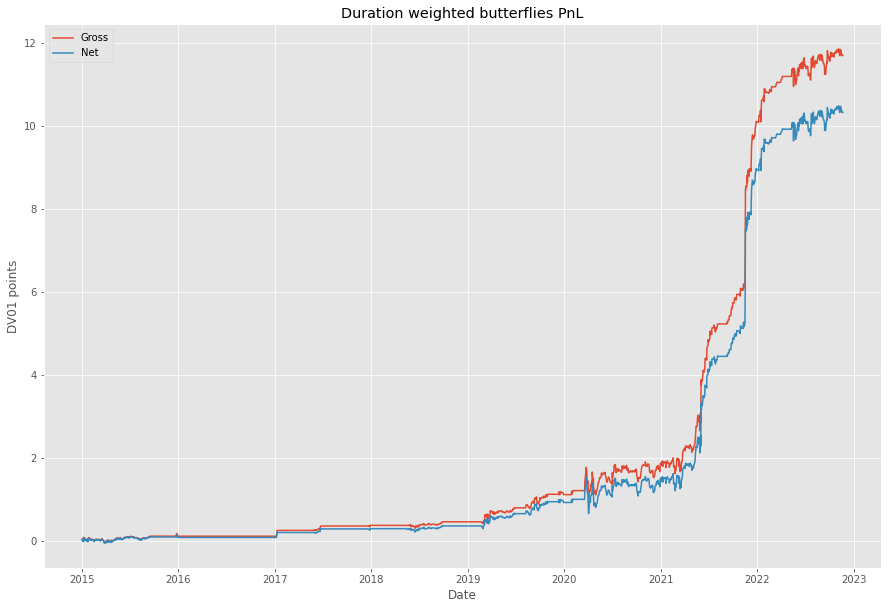

Johansen weighted butterflies performance
       Mean Ann  StdDev Ann  Sharpe
Gross      3.78        3.06    1.23
Net        3.28        3.04    1.08


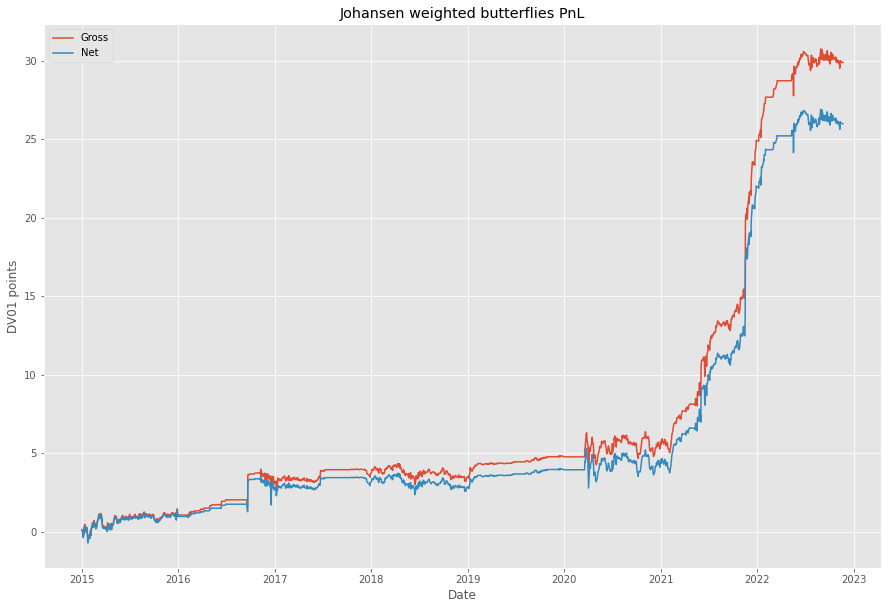

PCA weighted butterflies performance
       Mean Ann  StdDev Ann  Sharpe
Gross      2.92        1.95    1.50
Net        2.50        1.94    1.29


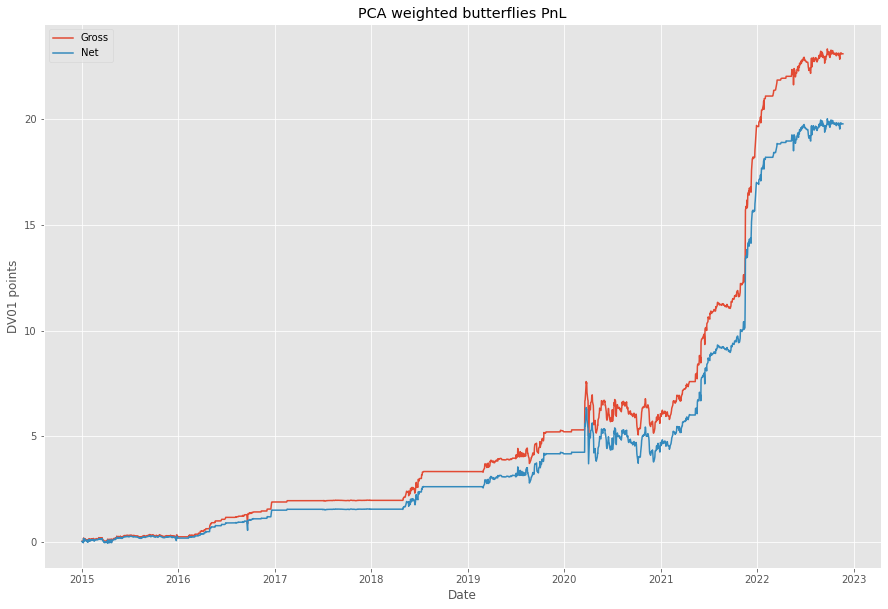

In [15]:
for (df_gross, df_costs, s) in [(df_dv_pnl, df_dv_costs, 'Duration weighted butterflies'),
                                (df_jo_pnl, df_jo_costs, 'Johansen weighted butterflies'),
                                (df_pca_pnl, df_pca_costs, 'PCA weighted butterflies')]:
    df = pd.DataFrame()
    df['gross'] = df_gross.sum(axis=1)
    df['net'] = (df_gross - df_costs).sum(axis=1)
    df_output = pd.DataFrame(index=['Gross', 'Net'], columns=['Mean Ann', 'StdDev Ann', 'Sharpe'])
    df_output.loc[['Gross', 'Net'], ['Mean Ann', 'StdDev Ann', 'Sharpe']] = [[
        260*df['gross'].mean(), sqrt(260) * df['gross'].std(), sqrt(260) * df['gross'].mean() / df['gross'].std()],
        [260*df['net'].mean(), sqrt(260) * df['net'].std(), sqrt(260) * df['net'].mean() / df['net'].std()]]
    print(s + ' performance')
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(df_output)
    #df.cumsum().iplot(title=s+' PnL', xTitle='Date', yTitle='DV01 points')
    plt.figure(figsize=(15, 10))
    plt.plot(df.cumsum())
    plt.title(s+' PnL')
    plt.xlabel('Date')
    plt.ylabel('DV01 points')
    plt.legend(['Gross', 'Net'], loc='best')
    plt.show()

Diversification across signals (here equal weight) produces better gross performance but costs approximately double because of rebalancing:

Duration weighted butterflies performance
       Mean Ann  StdDev Ann  Sharpe
Gross      0.79        0.55    1.44
Net        0.58        0.52    1.12


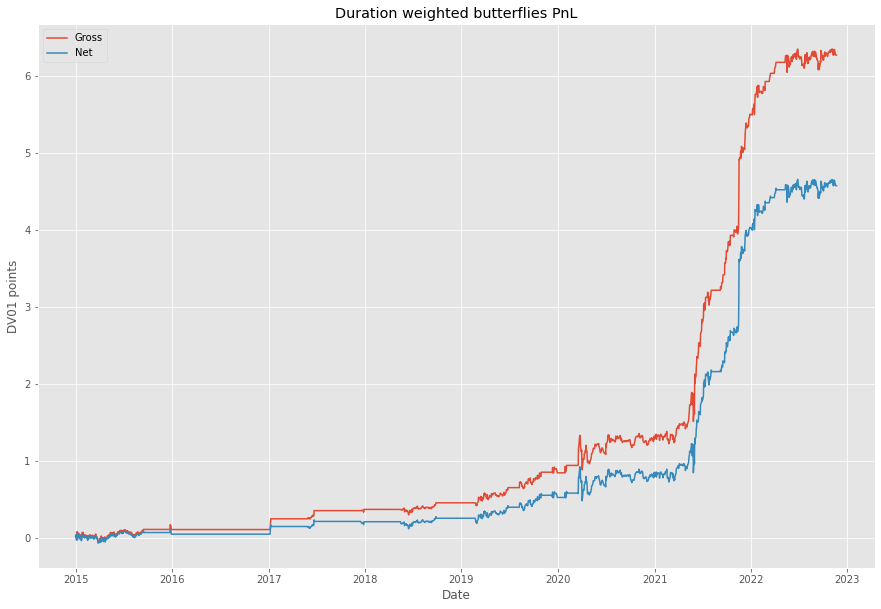

Johansen weighted butterflies performance
       Mean Ann  StdDev Ann  Sharpe
Gross      0.70        0.55    1.27
Net        0.44        0.54    0.82


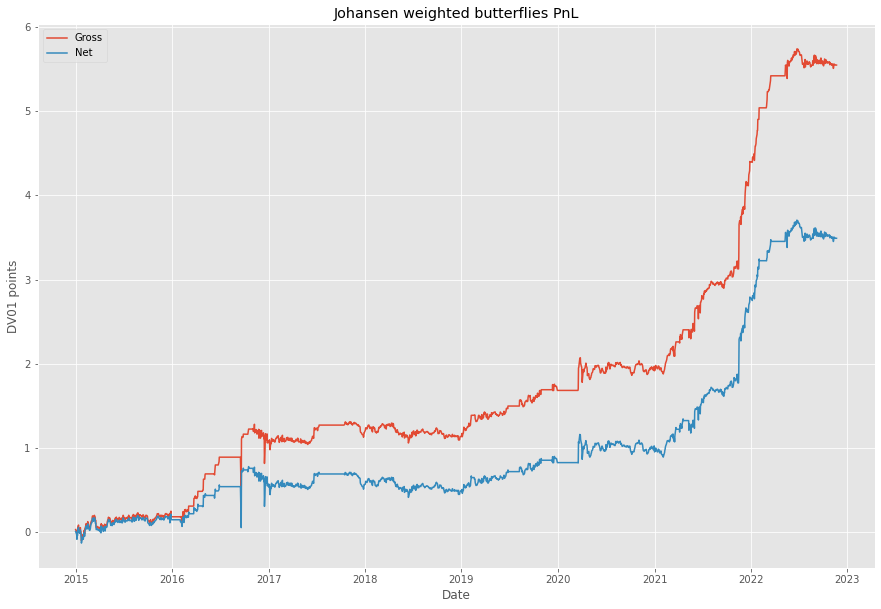

PCA weighted butterflies performance
       Mean Ann  StdDev Ann  Sharpe
Gross      0.87        0.51    1.70
Net        0.57        0.49    1.16


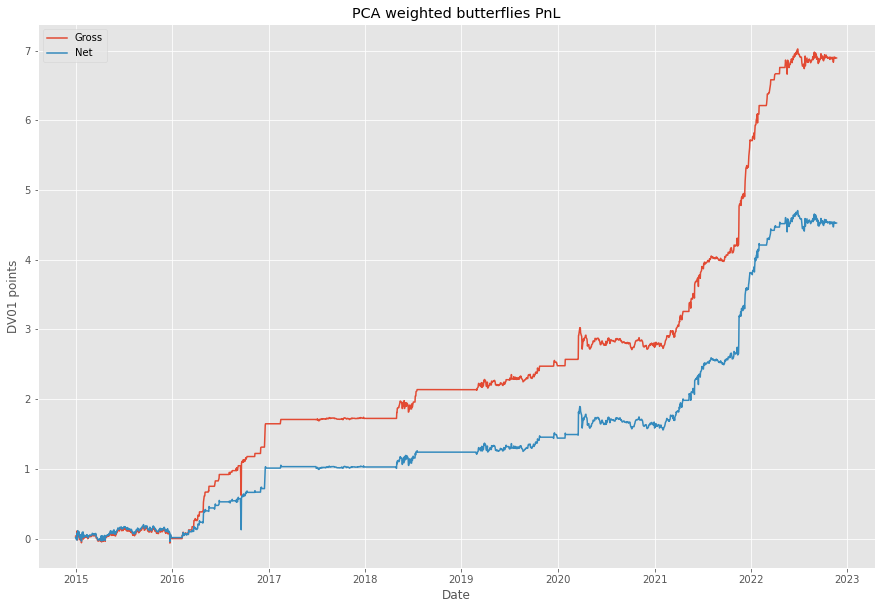

In [16]:
for (df_gross, df_costs, s) in [(df_dv_pnl, df_dv_costs, 'Duration weighted butterflies'),
                                (df_jo_pnl, df_jo_costs, 'Johansen weighted butterflies'),
                                (df_pca_pnl, df_pca_costs, 'PCA weighted butterflies')]:
    df = pd.DataFrame()
    df_net = df_gross - 2 * df_costs
    df['gross'] = df_gross.div(df_gross.replace(0, np.nan).notnull().sum(axis=1), axis=0).sum(axis=1)
    df['net'] = df_net.div(df_net.replace(0, np.nan).notnull().sum(axis=1), axis=0).sum(axis=1)
    df_output = pd.DataFrame(index=['Gross', 'Net'], columns=['Mean Ann', 'StdDev Ann', 'Sharpe'])
    df_output.loc[['Gross', 'Net'], ['Mean Ann', 'StdDev Ann', 'Sharpe']] = [[
        260*df['gross'].mean(), sqrt(260) * df['gross'].std(), sqrt(260) * df['gross'].mean() / df['gross'].std()],
        [260*df['net'].mean(), sqrt(260) * df['net'].std(), sqrt(260) * df['net'].mean() / df['net'].std()]]
    print(s + ' performance')
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(df_output)
    #df.cumsum().iplot(title=s+' PnL', xTitle='Date', yTitle='DV01 points')
    plt.figure(figsize=(15, 10))
    plt.plot(df.cumsum())
    plt.title(s+' PnL')
    plt.xlabel('Date')
    plt.ylabel('DV01 points')
    plt.legend(['Gross', 'Net'], loc='best')
    plt.show()

More flexible trading rule is probably needed in order to avoid overtrading.

Yearly model estimation is may be not frequent enough. We can do rolling daily reestimation

In [11]:
#rolling estimate
tenors = ['Y2', 'Y3', 'Y5', 'Y10', 'Y20']

lookback_years = 5
p_val_crit = 0.05
hl_crit = 20
sigma_crit = .025
z_ol = -1.5
z_cl = -.5
z_os = 1.5
z_cs = .5

start = df_zc.index[0] + pd.tseries.offsets.DateOffset(years=lookback_years)
dates = df_zc[df_zc.index >= start].index
df_pca_position = pd.DataFrame(index=dates)
df_jo_position = df_pca_position.copy()
df_dv_position = df_pca_position.copy()
df_pca_pnl = df_pca_position.copy()
df_jo_pnl = df_pca_position.copy()
df_dv_pnl = df_pca_position.copy()
dv_bf_weights = np.array([-0.5, 1.0, -0.5]).reshape(-1,1)
for date in tqdm(dates):
    prev_date = date + pd.tseries.offsets.DateOffset(days=-1)
    idx = pd.bdate_range(start=prev_date + pd.tseries.offsets.DateOffset(years=-lookback_years),
                        end=prev_date)
    train_idx = df_zc.index.intersection(idx)
    for j, t1 in enumerate(tenors):
        for k, t2 in enumerate(tenors[j+1:]):
            for t3 in tenors[j+k+2:]:
                dv_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(dv_bf_weights)
                if adfuller(dv_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl = fit_ou_params(dv_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        dv_bf_test = df_zc.loc[date, [t1, t2, t3]].dot(dv_bf_weights)
                        signal = (dv_bf_test - mu) / sigma_eq
                        if f'{t1}-{t2}-{t3}' not in df_dv_position.columns: df_dv_position[f'{t1}-{t2}-{t3}'] = 0 
                        if signal <= z_ol:
                            position = 1
                        elif signal >= z_os:
                            position = -1
                        elif (signal < z_cl) & (df_dv_position.shift(1).loc[date, f'{t1}-{t2}-{t3}'] == 1):
                            position = 1
                        elif (signal > z_cs) & (df_dv_position.shift(1).loc[date, f'{t1}-{t2}-{t3}'] == -1):
                            position = -1
                        else:
                            position = 0
                        df_dv_position.loc[date, f'{t1}-{t2}-{t3}'] = position
                        df_dv_pnl.loc[date, f'{t1}-{t2}-{t3}'] = position * df_zc.diff().shift(-1).\
                            loc[date, [t1, t2, t3]].dot(dv_bf_weights)
                pca_bf_weights = get_pca_bf_weights(df_zc.loc[train_idx, [t1, t2, t3]])
                pca_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(pca_bf_weights)
                if adfuller(pca_bf_ts)[1] < p_val_crit:
                    _, mu, sigma_eq, hl  = fit_ou_params(pca_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        pca_bf_test = df_zc.loc[date, [t1, t2, t3]].dot(pca_bf_weights)
                        signal = (pca_bf_test - mu) / sigma_eq
                        if f'{t1}-{t2}-{t3}' not in df_pca_position.columns: df_pca_position[f'{t1}-{t2}-{t3}'] = 0 
                        if signal <= z_ol:
                            position = 1
                        elif signal >= z_os:
                            position = -1
                        elif (signal < z_cl) & (df_pca_position.shift(1).loc[date, f'{t1}-{t2}-{t3}'] == 1):
                            position = 1
                        elif (signal > z_cs) & (df_pca_position.shift(1).loc[date, f'{t1}-{t2}-{t3}'] == -1):
                            position = -1
                        else:
                            position = 0
                        df_pca_position.loc[date, f'{t1}-{t2}-{t3}'] = position
                        df_pca_pnl.loc[date, f'{t1}-{t2}-{t3}'] = position * df_zc.diff().shift(-1).\
                            loc[date, [t1, t2, t3]].dot(pca_bf_weights)
                johansen = coint_johansen(df_zc.loc[train_idx, [t1, t2, t3]], det_order=1, k_ar_diff=1)
                if (johansen.lr1[0] > johansen.cvt[0,1]) & (johansen.lr2[0] > johansen.cvm[0,1]):
                    jo_bf_weights = (johansen.evec[:,0] / johansen.evec[1,0]).reshape(-1,1)
                    jo_bf_ts = df_zc.loc[train_idx, [t1, t2, t3]].dot(jo_bf_weights)
                    _, mu, sigma_eq, hl  = fit_ou_params(jo_bf_ts.values)
                    if (hl < hl_crit) & (sigma_eq > sigma_crit):
                        jo_bf_test = df_zc.loc[date, [t1, t2, t3]].dot(jo_bf_weights)
                        signal = (jo_bf_test - mu) / sigma_eq
                        if f'{t1}-{t2}-{t3}' not in df_jo_position.columns: df_jo_position[f'{t1}-{t2}-{t3}'] = 0 
                        if signal <= z_ol:
                            position = 1
                        elif signal >= z_os:
                            position = -1
                        elif (signal < z_cl) & (df_jo_position.shift(1).loc[date, f'{t1}-{t2}-{t3}'] == 1):
                            position = 1
                        elif (signal > z_cs) & (df_jo_position.shift(1).loc[date, f'{t1}-{t2}-{t3}'] == -1):
                            position = -1
                        else:
                            position = 0
                        df_jo_position.loc[date, f'{t1}-{t2}-{t3}'] = position
                        df_jo_pnl.loc[date, f'{t1}-{t2}-{t3}'] = position * df_zc.diff().shift(-1).\
                            loc[date, [t1, t2, t3]].dot(jo_bf_weights)

  0%|          | 0/2058 [00:00<?, ?it/s]

100%|██████████| 2058/2058 [45:51<00:00,  1.34s/it] 


Simple sum of signals performance
                          Mean Ann  StdDev Ann  Sharpe
Duration Neutral Weights      1.23        1.19    1.03
Johansen Weights              4.25        3.13    1.36
PCA Weights                   2.99        2.31    1.30


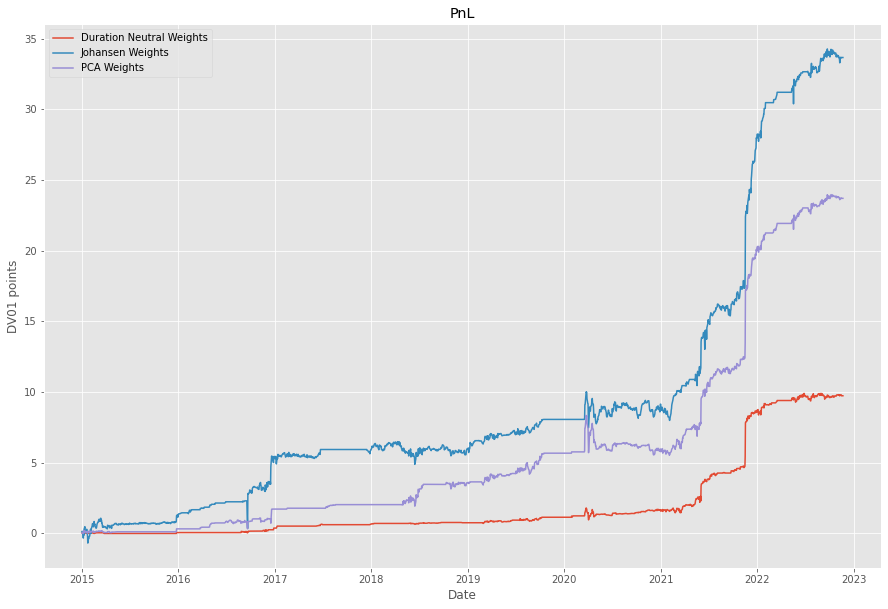

Equal weighted signals performance
                             Mean Ann  StdDev Ann  Sharpe
EW Duration Neutral Weights      0.81        0.64    1.26
EW Johansen Weights              0.82        0.53    1.54
EW PCA Weights                   0.76        0.59    1.30


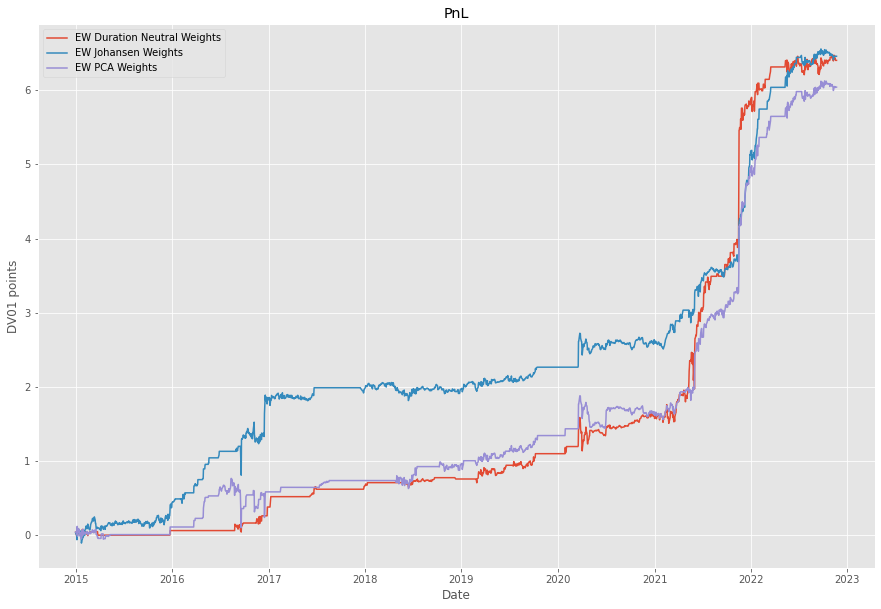

In [13]:
df = pd.DataFrame()
df['Duration Neutral Weights'] = df_dv_pnl.sum(axis=1)
df['Johansen Weights'] = df_jo_pnl.sum(axis=1)
df['PCA Weights'] = df_pca_pnl.sum(axis=1)
df_output = pd.DataFrame(index=['Duration Neutral Weights', 'Johansen Weights', 'PCA Weights'],
                        columns=['Mean Ann', 'StdDev Ann', 'Sharpe'])
df_output['Mean Ann'] = df.mean() * 260
df_output['StdDev Ann'] = df.std() * sqrt(260)
df_output['Sharpe'] = df_output['Mean Ann'] / df_output['StdDev Ann']
print('Simple sum of signals performance')
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(df_output)
#df.cumsum().iplot(title='PnL', xTitle='Date', yTitle='DV01 points')
plt.figure(figsize=(15, 10))
plt.plot(df.cumsum())
plt.title('PnL')
plt.xlabel('Date')
plt.ylabel('DV01 points')
plt.legend(df_output.index, loc='best')
plt.show()

df = pd.DataFrame()
df['EW Duration Neutral Weights'] = df_dv_pnl.div(df_dv_position.abs().sum(axis=1), axis=0).sum(axis=1)
df['EW Johansen Weights'] = df_jo_pnl.div(df_jo_position.abs().sum(axis=1), axis=0).sum(axis=1)
df['EW PCA Weights'] = df_pca_pnl.div(df_pca_position.abs().sum(axis=1), axis=0).sum(axis=1)
df_output = pd.DataFrame(index=['EW Duration Neutral Weights', 'EW Johansen Weights', 'EW PCA Weights'],
                        columns=['Mean Ann', 'StdDev Ann', 'Sharpe'])
df_output['Mean Ann'] = df.mean() * 260
df_output['StdDev Ann'] = df.std() * sqrt(260)
df_output['Sharpe'] = df_output['Mean Ann'] / df_output['StdDev Ann']
print('Equal weighted signals performance')
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(df_output)
#df.cumsum().iplot(title='PnL', xTitle='Date', yTitle='DV01 points')
plt.figure(figsize=(15, 10))
plt.plot(df.cumsum())
plt.title('PnL')
plt.xlabel('Date')
plt.ylabel('DV01 points')
plt.legend(df_output.index, loc='best')
plt.show()

Frequent reestimation of parameters only marginally improves the performance.